In [69]:
import numpy as np
import pandas as pd
import os
import shutil
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report

In [70]:
DATA_PATH = "../data/UTKFace"
WEIGHTS_PATH = '../train_weight'

IM_HEIGHT = IM_WIDTH = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

In [71]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        #print(filepath)
        return None, None, None

In [72]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

files = list_files(DATA_PATH)

In [73]:
attributes = list(map(parse_filepath, files))

In [74]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df = df.drop_duplicates()
df.head()

,age,gender,race,file
0,82.0,male,asian,../data/UTKFace/82_0_2_20170111210110290.jpg.c...
1,32.0,female,asian,../data/UTKFace/32_1_2_20170116180211518.jpg.c...
2,21.0,male,others,../data/UTKFace/21_0_4_20170103225103768.jpg.c...
3,27.0,female,asian,../data/UTKFace/27_1_2_20170116171716287.jpg.c...
4,26.0,male,others,../data/UTKFace/26_0_4_20170117153355923.jpg.c...


# Exploratory Analysis

## Raw Data

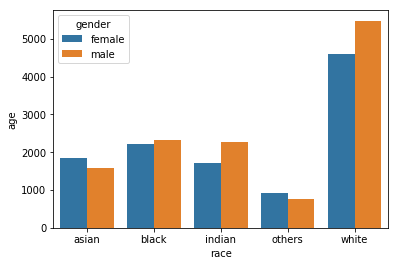

In [75]:
x = pd.DataFrame(df.groupby(by=['race', 'gender'])['age'].count())
x.reset_index(inplace=True)
ax = sns.barplot(x="race", y="age", hue="gender", data=x)

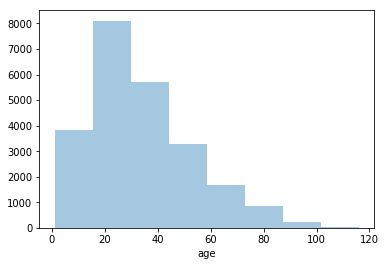

In [76]:
sns.distplot(df['age'], bins = 8, kde=False);

## Preprocessing
### Create Baseline Dataset

First we remove ages that are likely to make gender identification challenging.

In [9]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

Let's revisit the EDA using the baseline dataset.  This dataset ("df") will be used for our baseline model.

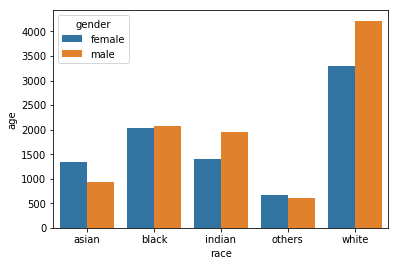

In [10]:
y = pd.DataFrame(df.groupby(by=['race', 'gender'])['age'].count())
y.reset_index(inplace=True)
ax = sns.barplot(x="race", y="age", hue="gender", data=y)

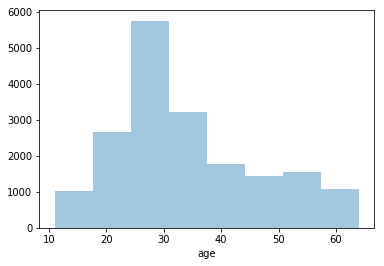

In [11]:
sns.distplot(df['age'], bins = 8, kde=False);

### Create Ethnically Balanced Dataset (skip this part for now)

The baseline dataset contain 18,529 images (see below).

In [12]:
base_len = len(df)
print('Baseline dataset length:{0}'.format(base_len))

Baseline dataset length:18529


There are 10 gender-ethnicity combinations. Let's create a balanced data set similar in size to the baseline dataset, but with equally distributed gender-ethniticy combinations each containing 1,852 images (see below).

In [13]:
bal_subgrp_len = base_len // 10
print('Balanced subgroup length:{0}'.format(bal_subgrp_len))

Balanced subgroup length:1852


To achive this, we will randomly downsample subgroups with more than 1,852 images, and upsample subgroups with fewer than 1,852 images.

In [14]:
# get all gender-ethnicity combinations


# create dataframe with equally distributed subgroups (without age consideration)
def gen_df(df, rows, seed):
    if len(df) > rows:
        new_df = df.sample(n=rows,random_state=seed)
    else:
        x = len(df) // rows
        for i in range(x)



SyntaxError: invalid syntax (<ipython-input-14-86271df2db6b>, line 10)

Let's revisit the EDA using the balanced dataset ("df_bal").

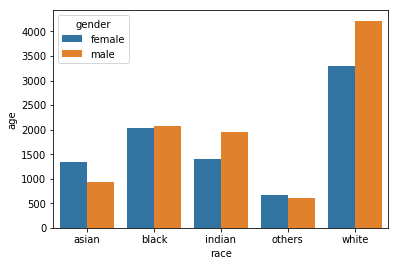

In [15]:
y = pd.DataFrame(df.groupby(by=['race', 'gender'])['age'].count())
y.reset_index(inplace=True)
ax = sns.barplot(x="race", y="age", hue="gender", data=y)

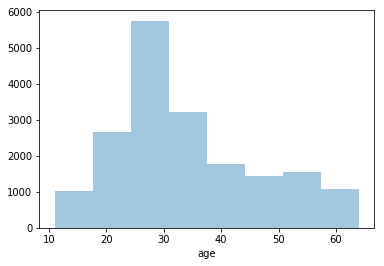

In [16]:
sns.distplot(df['age'], bins = 8, kde=False);

-----need to add  more here----

# Custom Generator Function

In [77]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, for_training, batch_size=16):
    images, ages, races, genders, files = [], [], [], [], []
    while True:
        for i, r in df.iterrows():
            file, age, race, gender = r['file'], r['age'], r['race'], r['gender']
            
            # image preprocessing
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            
            ages.append(age)
            races.append(race)
            gender_id = GENDER_ID_MAP[gender]
            genders.append(to_categorical(gender_id, 2))
            files.append(file)
            if len(images) >= batch_size:
                if for_training:
                    yield np.array(images), np.array(genders)
                else:
                     yield np.array(images), np.array(genders), np.array(races), np.array(ages), np.array(files)
                images, ages, races, genders, files = [], [], [], [], []
        if not for_training:
            break

# Custom Train Val Test Split Function

In [78]:
from keras.utils import to_categorical
from PIL import Image
from imgaug import augmenters as iaa
import random

def get_data_generator(df, for_training=True, batch_size=16, flip_add_noise=False, flip_p=.5):
    images, ages, races, genders, files = [], [], [], [], []

    #Function to flip and add noise
    def flip_add_noise(input_img):
        aug = iaa.CoarseDropout(0.02, size_percent=0.7, per_channel=0.7)
        seq_object = iaa.Sequential([aug])
        return seq_object.augment_images([np.fliplr(input_img)])[0].astype('float32')
    
    while True:
        for i, r in df.iterrows():
            file, age, race, gender = r['file'], r['age'], r['race'], r['gender']
            
            # image preprocessing
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            
            #Flipping and adding noise to random images
            if flip_add_noise == True:
                y=np.random.binomial(1, flip_p)
                if y==1 :
                    im=flip_add_noise(im)
                else:
                    im=im
                
            im = np.array(im) / 255.0
            images.append(im)
            
            ages.append(age)
            races.append(race)
            gender_id = GENDER_ID_MAP[gender]
            genders.append(to_categorical(gender_id, 2))
            files.append(file)
            if len(images) >= batch_size:
                if for_training:
                    yield np.array(images), np.array(genders)
                else:
                     yield np.array(images), np.array(genders), np.array(races), np.array(ages), np.array(files)
                images, ages, races, genders, files = [], [], [], [], []
        if not for_training:
            break

In [79]:
def train_val_test_split(df, test_size, val_size, random_state):

    model_df , test_df = train_test_split(df, test_size = test_size, shuffle = True , random_state = random_state,
                                                  stratify = df[['gender','race']])

    train_df , val_df = train_test_split(model_df, test_size = val_size, shuffle = True , random_state = random_state,
                                                  stratify = model_df[['gender','race']])

    return train_df, val_df, test_df

# Model

In [80]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True, drp_out=False):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if drp_out :
        _ = Dropout(0.3)(_)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape= (IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3, drp_out=True)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5, drp_out=True)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=2, activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[gender_output])
model.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 198, 198, 3)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 196, 196, 32)      896       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 194, 194, 64)      18496     
_________________________________________________________________
batch_normalization_28 (Batc (None, 194, 194, 64)      256       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 97, 97, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 95, 95, 96)        55392     
_________________________________________________________________
dropout_13 (Dropout)         (None, 95, 95, 96)        0         
__________

# Baseline Run

In [81]:
run_type = 'baseline'
epochs = 10

In [82]:
train_df, val_df, test_df = train_val_test_split(df=df, test_size=0.1, val_size=0.3, random_state=44)

len(train_df), len(val_df), len(test_df)

(14933, 6401, 2371)

In [83]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(train_df, for_training=True, batch_size=batch_size,flip_add_noise=False, flip_p=.5)
valid_gen = get_data_generator(val_df, for_training=True, batch_size=valid_batch_size,flip_add_noise=False, flip_p=.5)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_df)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val_df)//valid_batch_size)
                    

Epoch 1/10
 15/233 [>.............................] - ETA: 2:36 - loss: 1.8892 - acc: 0.5333

KeyboardInterrupt: 

In [32]:
model.save_weights('train_weight/' + run_type + '_' + str(epochs) + '_epochs.w')

In [26]:
#model.load_weights(folder + '/cropped_conv_gender_epochs10_binary.w')
os.getcwd()

'/jupyteruser/41320362/Algorithmic-Biases-in-Facial-Recognition'

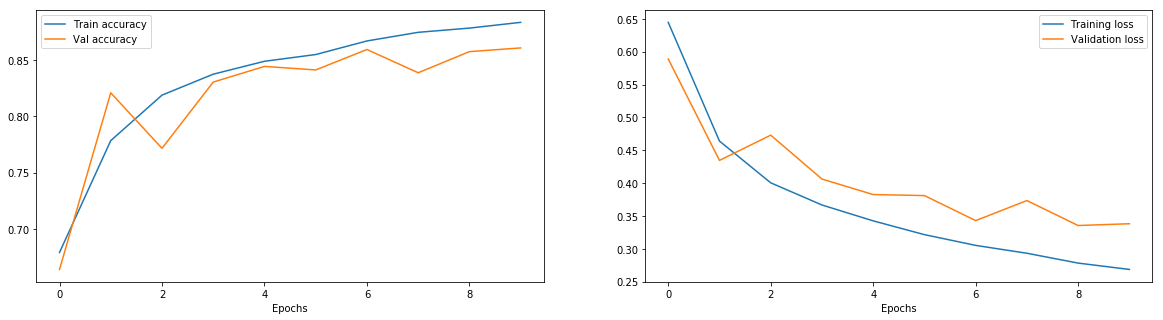

In [33]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    axes[0].plot(history.history['acc'], label='Train accuracy')
    axes[0].plot(history.history['val_acc'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [34]:
test_gen = get_data_generator(test_df, for_training=False, batch_size=128)
true_list = []
pred_list = []
race_list = []
age_list  = []
file_list = []
for i, batch in enumerate(test_gen):
    batch_pred = model.predict_on_batch(batch[0]).tolist()
    batch_true = batch[1].tolist()
    batch_race = batch[2].tolist()
    batch_age  = batch[3].tolist()
    batch_file = batch[4].tolist()    

    for t in batch_true:
        true_list.append(t)
    for p in batch_pred:
        pred_list.append(p)
    for r in batch_race:
        race_list.append(r)
    for a in batch_age:
        age_list.append(a)        
    for f in batch_file:
        file_list.append(f)          

In [35]:
gender_true = np.array(true_list).argmax(axis=-1)
gender_pred = np.array(pred_list).argmax(axis=-1)
races = np.array(race_list)
ages = np.array(age_list)
files = np.array(file_list)

In [36]:
df_preds = pd.DataFrame(list(zip(races, gender_true, gender_pred, ages, files)), 
                        columns=['race','gender_true','gender_pred','age','file'])

In [18]:
unique_races = df_preds['race'].unique()

In [19]:
for race in unique_races:  
    print("\nClassification report for gender where race = {}".format(race))
    print(classification_report(df_preds[df_preds['race'] == race]['gender_true'], 
                                df_preds[df_preds['race'] == race]['gender_pred']))


Classification report for gender where race = white
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       534
           1       0.86      0.81      0.84       451

   micro avg       0.85      0.85      0.85       985
   macro avg       0.86      0.85      0.85       985
weighted avg       0.86      0.85      0.85       985


Classification report for gender where race = indian
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       221
           1       0.84      0.84      0.84       165

   micro avg       0.86      0.86      0.86       386
   macro avg       0.86      0.86      0.86       386
weighted avg       0.86      0.86      0.86       386


Classification report for gender where race = black
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       228
           1       0.91      0.87      0.89       211

   micro avg       0.9

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('g:{}, r:{}'.format(ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('g:{}, r:{}'.format(ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    

## Downsampling

In [37]:
#Down data to balance the data set
def downsample(base_df,univ_df,race):
    n=univ_df.loc[df.race=='others'].shape[0]   
    temp=univ_df.loc[df.race==race]
    smpl=temp.sample(n,replace=True)
    df1=base_df.append(smpl)    
    return df1

base_down=train_df.append(val_df)
df_down=base_down.loc[base_down.race=='others']
df_down=downsample(df_down,base_down,'black',)
df_down=downsample(df_down,base_down,'indian')
df_down=downsample(df_down,base_down,'asian')
df_down=downsample(df_down,base_down,'white')

In [38]:
df_down.race.value_counts()

white     1523
others    1523
indian    1523
black     1523
asian     1523
Name: race, dtype: int64

In [39]:
train_down, val_down = train_test_split(df_down)

In [40]:
from keras.callbacks import ModelCheckpoint


model_imprv = Model(inputs=input_layer, outputs=[gender_output])

model_imprv.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})
epochs=10
batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(train_down, for_training=True, batch_size=batch_size, flip_add_noise=False)
valid_gen = get_data_generator(val_down, for_training=True, batch_size=valid_batch_size)

callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]

history = model_imprv.fit_generator(train_gen,
                    steps_per_epoch=len(train_down)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(train_down)//valid_batch_size)
                    

Epoch 1/10
89/89 [==============================] - 37s 421ms/step - loss: 0.2870 - acc: 0.8775 - val_loss: 0.3094 - val_acc: 0.8690
Epoch 2/10
89/89 [==============================] - 36s 402ms/step - loss: 0.2566 - acc: 0.8938 - val_loss: 0.3258 - val_acc: 0.8627
Epoch 3/10
89/89 [==============================] - 36s 405ms/step - loss: 0.2372 - acc: 0.9005 - val_loss: 0.2991 - val_acc: 0.8666
Epoch 4/10
89/89 [==============================] - 36s 406ms/step - loss: 0.2124 - acc: 0.9156 - val_loss: 0.2871 - val_acc: 0.8854
Epoch 5/10
89/89 [==============================] - 36s 401ms/step - loss: 0.2035 - acc: 0.9154 - val_loss: 0.3728 - val_acc: 0.8287
Epoch 6/10
89/89 [==============================] - 36s 405ms/step - loss: 0.1887 - acc: 0.9243 - val_loss: 0.2966 - val_acc: 0.8725
Epoch 7/10
89/89 [==============================] - 36s 406ms/step - loss: 0.1806 - acc: 0.9287 - val_loss: 0.2733 - val_acc: 0.8885
Epoch 8/10
89/89 [==============================] - 36s 407ms/step - 

In [41]:
model.save_weights('train_weight/downsample_' + run_type + '_' + str(epochs) + '_epochs.w')

In [42]:
test_gen = get_data_generator(test_df, for_training=False, batch_size=128)
true_list = []
pred_list = []
race_list = []
age_list  = []
file_list = []
for i, batch in enumerate(test_gen):
    batch_pred = model_imprv.predict_on_batch(batch[0]).tolist()
    batch_true = batch[1].tolist()
    batch_race = batch[2].tolist()
    batch_age  = batch[3].tolist()
    batch_file = batch[4].tolist()    

    for t in batch_true:
        true_list.append(t)
    for p in batch_pred:
        pred_list.append(p)
    for r in batch_race:
        race_list.append(r)
    for a in batch_age:
        age_list.append(a)        
    for f in batch_file:
        file_list.append(f)          

In [43]:
gender_true = np.array(true_list).argmax(axis=-1)
gender_pred = np.array(pred_list).argmax(axis=-1)
races = np.array(race_list)
ages = np.array(age_list)
files = np.array(file_list)

In [44]:
df_preds = pd.DataFrame(list(zip(races, gender_true, gender_pred, ages, files)), 
                        columns=['race','gender_true','gender_pred','age','file'])

In [45]:
unique_races = df_preds['race'].unique()

In [231]:
for race in unique_races:  
    print("\nClassification report for gender where race = {}".format(race))
    print(classification_report(df_preds[df_preds['race'] == race]['gender_true'], 
                                df_preds[df_preds['race'] == race]['gender_pred']))


Classification report for gender where race = white
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       406
           1       0.86      0.98      0.91       323

   micro avg       0.92      0.92      0.92       729
   macro avg       0.92      0.92      0.92       729
weighted avg       0.92      0.92      0.92       729


Classification report for gender where race = asian
              precision    recall  f1-score   support

           0       0.98      0.87      0.92        91
           1       0.91      0.98      0.95       129

   micro avg       0.94      0.94      0.94       220
   macro avg       0.94      0.93      0.93       220
weighted avg       0.94      0.94      0.94       220


Classification report for gender where race = indian
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       183
           1       0.87      0.98      0.92       136

   micro avg       0.9

## Upsampling

In [47]:
#Upsampling data to balance the data set

def upsample(df,race):
    n=df.loc[df.race=='white'].shape[0]-df.loc[df.race==race].shape[0]
    temp=df.loc[df.race==race]
    smpl=temp.sample(n,replace=True)
    df=df.append(smpl)
    return df

base_up=train_df.append(val_df)
df_up=upsample(base_up,'black',)
df_up=upsample(df_up,'indian')
df_up=upsample(df_up,'asian')
df_up=upsample(df_up,'others')

In [189]:
df_up.race.value_counts()


white     6755
black     6755
asian     6755
others    6755
indian    6755
Name: race, dtype: int64

### Data Generator to add noise and flipping (I have added condition for adding noise so that we can have just one generator to serve all our needs)

In [48]:
train_upsmpl, val_upsmpl = train_test_split(df_up)

In [49]:
from keras.callbacks import ModelCheckpoint


model_imprv = Model(inputs=input_layer, outputs=[gender_output])

model_imprv.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(train_upsmpl, for_training=True, batch_size=batch_size, flip_add_noise=True)
valid_gen = get_data_generator(val_upsmpl, for_training=True, batch_size=valid_batch_size)

callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]

history = model_imprv.fit_generator(train_gen,
                    steps_per_epoch=len(train_upsmpl)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val_upsmpl)//valid_batch_size)
                    

Epoch 1/10
531/531 [==============================] - 178s 335ms/step - loss: 0.2638 - acc: 0.8873 - val_loss: 0.2915 - val_acc: 0.8919
Epoch 2/10
531/531 [==============================] - 177s 333ms/step - loss: 0.2271 - acc: 0.9060 - val_loss: 0.2838 - val_acc: 0.8865
Epoch 3/10
531/531 [==============================] - 182s 343ms/step - loss: 0.2080 - acc: 0.9141 - val_loss: 0.2411 - val_acc: 0.9135
Epoch 4/10
531/531 [==============================] - 177s 333ms/step - loss: 0.1889 - acc: 0.9233 - val_loss: 0.2174 - val_acc: 0.9267
Epoch 5/10
531/531 [==============================] - 177s 333ms/step - loss: 0.1816 - acc: 0.9271 - val_loss: 0.2268 - val_acc: 0.9264
Epoch 6/10
531/531 [==============================] - 182s 342ms/step - loss: 0.1654 - acc: 0.9347 - val_loss: 0.2036 - val_acc: 0.9306
Epoch 7/10
531/531 [==============================] - 177s 333ms/step - loss: 0.1540 - acc: 0.9388 - val_loss: 0.2107 - val_acc: 0.9231
Epoch 8/10
531/531 [============================

In [53]:
model.save_weights('train_weight/upsample_' + run_type + '_' + str(epochs) + '_epochs.w')

In [54]:
run_type = 'upsampling'
epochs = 10

In [55]:
model_imprv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 198, 198, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 196, 196, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 194, 194, 32)      4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 194, 194, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 95, 95, 48)        13872     
_________________________________________________________________
dropout_3 (Dropout)          (None, 95, 95, 48)        0         
__________

In [56]:
test_gen = get_data_generator(test_df, for_training=False, batch_size=128)
true_list = []
pred_list = []
race_list = []
age_list  = []
file_list = []
for i, batch in enumerate(test_gen):
    batch_pred = model_imprv.predict_on_batch(batch[0]).tolist()
    batch_true = batch[1].tolist()
    batch_race = batch[2].tolist()
    batch_age  = batch[3].tolist()
    batch_file = batch[4].tolist()    

    for t in batch_true:
        true_list.append(t)
    for p in batch_pred:
        pred_list.append(p)
    for r in batch_race:
        race_list.append(r)
    for a in batch_age:
        age_list.append(a)        
    for f in batch_file:
        file_list.append(f)          

In [57]:
gender_true = np.array(true_list).argmax(axis=-1)
gender_pred = np.array(pred_list).argmax(axis=-1)
races = np.array(race_list)
ages = np.array(age_list)
files = np.array(file_list)

In [58]:
df_preds = pd.DataFrame(list(zip(races, gender_true, gender_pred, ages, files)), 
                        columns=['race','gender_true','gender_pred','age','file'])

In [59]:
unique_races = df_preds['race'].unique()

In [209]:
for race in unique_races:  
    print("\nClassification report for gender where race = {}".format(race))
    print(classification_report(df_preds[df_preds['race'] == race]['gender_true'], 
                                df_preds[df_preds['race'] == race]['gender_pred']))


Classification report for gender where race = white
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       406
           1       0.90      0.90      0.90       323

   micro avg       0.91      0.91      0.91       729
   macro avg       0.91      0.91      0.91       729
weighted avg       0.91      0.91      0.91       729


Classification report for gender where race = asian
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        91
           1       0.93      0.96      0.95       129

   micro avg       0.94      0.94      0.94       220
   macro avg       0.94      0.93      0.93       220
weighted avg       0.94      0.94      0.94       220


Classification report for gender where race = indian
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       183
           1       0.91      0.92      0.91       136

   micro avg       0.9

In [93]:
df_up.iloc[100]['file']

'/jupyteruser/41400447/Project/UTKFace/20_1_1_20170112230604949.jpg.chip.jpg'

In [94]:
for layer in model_imprv.layers:
    print(layer.name)

input_1
conv2d_1
conv2d_2
batch_normalization_1
max_pooling2d_1
conv2d_3
batch_normalization_2
max_pooling2d_2
conv2d_4
batch_normalization_3
max_pooling2d_3
conv2d_5
batch_normalization_4
max_pooling2d_4
conv2d_6
batch_normalization_5
max_pooling2d_5
global_max_pooling2d_1
dense_1
gender_output


In [95]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

In [98]:
test_img=plt.imread('/jupyteruser/41400447/Project/UTKFace/20_1_1_20170112230604949.jpg.chip.jpg')
def plot_saliency(img=test_img, layer_nm='gender_output',model=model_imprv):
    layer_ind=utils.find_layer_idx(model,layer_nm)
    model.layers[layer_ind].activation = activations.linear
    model = utils.apply_modifications(model)
    grads = visualize_saliency(model, layer_ind, filter_indices=0,  seed_input=img)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle('Gravitational wave', y=0.8)
    ax1.set_title('Original image')
    ax2.set_title('Saliency map for {name}'.format(name=layer_nm))
    ax1.imshow(img[:,:,:])
    ax2.imshow(grads, cmap='jet')
    ax1.set_axis_off()
    ax2.set_axis_off()

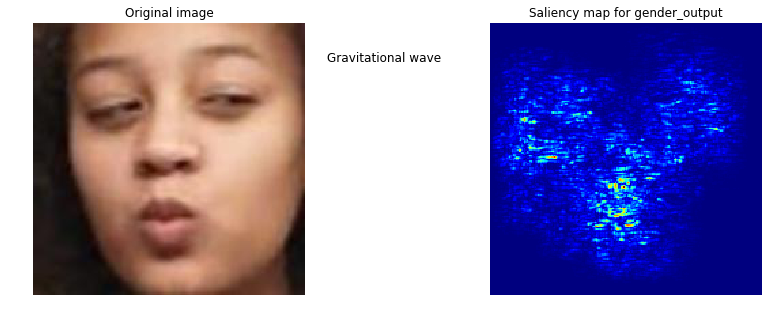

In [99]:
plot_saliency(img=test_img, layer_nm='gender_output', model=model_imprv)

## Adding more noise (50% of images)

In [212]:
from keras.callbacks import ModelCheckpoint


model_imprv = Model(inputs=input_layer, outputs=[gender_output])

model_imprv.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})
epochs=2
batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(train_upsmpl, for_training=True, batch_size=batch_size, flip_add_noise=True)
valid_gen = get_data_generator(val_upsmpl, for_training=True, batch_size=valid_batch_size)

callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]

history = model_imprv.fit_generator(train_gen,
                    steps_per_epoch=len(train_upsmpl)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val_upsmpl)//valid_batch_size)
                    

Epoch 1/2
395/395 [==============================] - 137s 346ms/step - loss: 0.0559 - acc: 0.9816 - val_loss: 0.1295 - val_acc: 0.9596
Epoch 2/2
395/395 [==============================] - 133s 336ms/step - loss: 0.0548 - acc: 0.9817 - val_loss: 0.1188 - val_acc: 0.9597


In [194]:
model_imprv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 198, 198, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 196, 196, 16)      448       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 194, 194, 32)      4640      
_________________________________________________________________
batch_normalization_24 (Batc (None, 194, 194, 32)      128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 95, 95, 48)        13872     
_________________________________________________________________
dropout_8 (Dropout)          (None, 95, 95, 48)        0         
__________

In [213]:
test_gen = get_data_generator(test_df, for_training=False, batch_size=128)
true_list = []
pred_list = []
race_list = []
age_list  = []
file_list = []
for i, batch in enumerate(test_gen):
    batch_pred = model_imprv.predict_on_batch(batch[0]).tolist()
    batch_true = batch[1].tolist()
    batch_race = batch[2].tolist()
    batch_age  = batch[3].tolist()
    batch_file = batch[4].tolist()    

    for t in batch_true:
        true_list.append(t)
    for p in batch_pred:
        pred_list.append(p)
    for r in batch_race:
        race_list.append(r)
    for a in batch_age:
        age_list.append(a)        
    for f in batch_file:
        file_list.append(f)          

In [214]:
gender_true = np.array(true_list).argmax(axis=-1)
gender_pred = np.array(pred_list).argmax(axis=-1)
races = np.array(race_list)
ages = np.array(age_list)
files = np.array(file_list)

In [215]:
df_preds = pd.DataFrame(list(zip(races, gender_true, gender_pred, ages, files)), 
                        columns=['race','gender_true','gender_pred','age','file'])

In [216]:
unique_races = df_preds['race'].unique()

In [217]:
for race in unique_races:  
    print("\nClassification report for gender where race = {}".format(race))
    print(classification_report(df_preds[df_preds['race'] == race]['gender_true'], 
                                df_preds[df_preds['race'] == race]['gender_pred']))


Classification report for gender where race = white
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       406
           1       0.89      0.93      0.91       323

   micro avg       0.92      0.92      0.92       729
   macro avg       0.91      0.92      0.92       729
weighted avg       0.92      0.92      0.92       729


Classification report for gender where race = asian
              precision    recall  f1-score   support

           0       0.96      0.89      0.93        91
           1       0.93      0.98      0.95       129

   micro avg       0.94      0.94      0.94       220
   macro avg       0.95      0.93      0.94       220
weighted avg       0.94      0.94      0.94       220


Classification report for gender where race = indian
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       183
           1       0.89      0.95      0.92       136

   micro avg       0.9